In [1]:
#=======================================================================
# Forecast ENSO using the Yule-Walker Equations (covariance modeling)
#=======================================================================
import sys,warnings,os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from matplotlib.ticker import MultipleLocator

warnings.simplefilter('ignore')

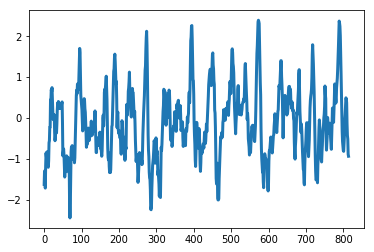

In [2]:
#=======================================================================
# Load ENSO
#=======================================================================
ENSO = {}
ENSO['year'],ENSO['month'],ENSO['index'] = np.loadtxt('ENSO.txt',skiprows=3,unpack=True)
ENSO['date'] = np.asarray([datetime(int(y),int(m),15) for y,m in zip(ENSO['year'],ENSO['month'])])

plt.figure()
plt.plot(ENSO['index'],lw=3)
plt.show(block=False)

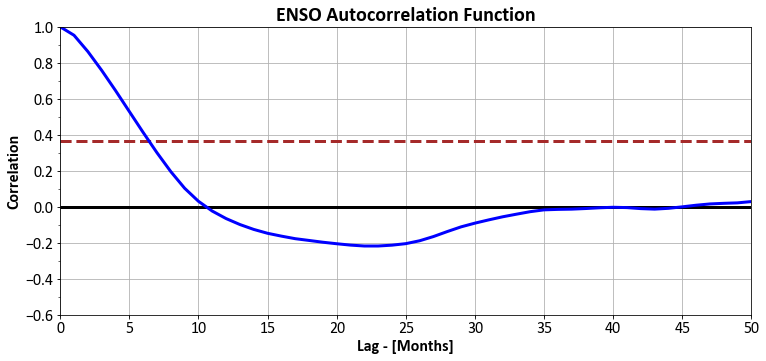

In [3]:
#=======================================================================
# Calculate the autocorrelation for ENSO index.
#=======================================================================
def autocorr(x,length=20):
    acf = np.ones((length+1,))
    for l in range(1,length+1):
        anom1 = x[:-l] - np.nanmean(x[:-l])
        anom2 = x[l:] - np.nanmean(x[l:])
        std1 = np.nanstd(x[:-l])
        std2 = np.nanstd(x[l:])
        
        acf[l] = np.dot(anom1,anom2)/float(anom1.size)/std1/std2
    return acf

ENSO_ACF = autocorr(ENSO['index'],length=50)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_position([0.1,0.1,0.8,0.5])
ax.plot(np.arange(51),ENSO_ACF,'b-',lw=3)
ax.hlines(xmin=0,xmax=50,y=np.exp(-1),color='brown',linestyle='dashed',\
          linewidth=3)
ax.hlines(xmin=0,xmax=50,y=0,color='black',linestyle='solid',linewidth=3)
ax.grid(True)
ax.set(xlim=[0,50],ylim=[-0.6,1],xticks=np.arange(0,51,5),yticks=np.arange(-0.6,1.1,0.2))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_title('ENSO Autocorrelation Function',weight='bold',size=20,name='Calibri')
ax.set_xlabel('Lag - [Months]',weight='bold',size=16,name='Calibri')
ax.set_ylabel('Correlation',weight='bold',size=16,name='Calibri')
for i in ax.xaxis.get_ticklabels()+ax.yaxis.get_ticklabels():
    i.set_family('Calibri')
    i.set_size(16)

plt.show(block=False)

In [9]:
#=======================================================================
# Build an AR-N model for forecasting
#=======================================================================
def ARModel(tseries,ORDER=1):
    
    y = tseries[ORDER:]
    x = np.ones((ORDER,y.size))*np.nan
    
    t = tseries.size
    
    for n in range(1,ORDER+1):
        x[n-1,:] = tseries[ORDER-n:t-n]

    Cyx = np.dot(y,x.T)/float(t)
    Cxx = np.dot(x,x.T)/float(t)
    Cxxi = np.linalg.inv(Cxx)
    
    alpha = Cyx.dot(Cxxi)
    yhat = alpha.dot(x)
    
    return alpha,yhat


In [10]:
#=======================================================================
# Run the model
#=======================================================================
ORDER = 20
print ENSO['index'].shape
alpha,ENSOrec = ARModel(ENSO['index'],ORDER=ORDER)

# Shift the time arrays to line up with the new y.
year = ENSO['year'][ORDER:]
month = ENSO['month'][ORDER:]
date = ENSO['date'][ORDER:]

print alpha


(815,)
[ 1.43719039 -0.59706156  0.16001632 -0.02279015 -0.0193362  -0.0133289
 -0.03273328  0.04394611 -0.16954117  0.15815835 -0.05187061  0.0384698
  0.01194366 -0.03392555 -0.00155991  0.03690955 -0.06506378  0.06273629
 -0.04739582  0.00374958]


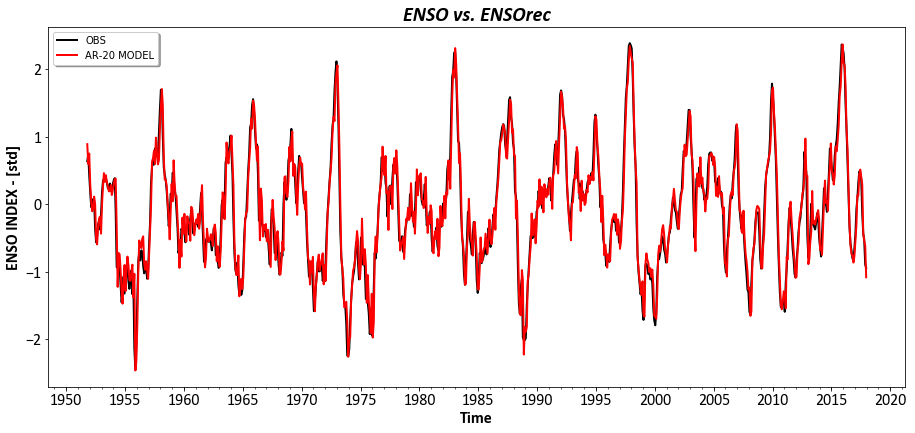

In [11]:
#=======================================================================
# Make a plot of the actual and reconstructed.
#=======================================================================
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)
ax.set_position([0.1,0.1,0.85,0.5])
ax.plot(date,ENSO['index'][ORDER:],'k-',lw=2,label='OBS')
ax.plot(date,ENSOrec,'r-',lw=2,label='AR-%d MODEL'%ORDER)
ax.set_title('ENSO vs. ENSOrec',name='Calibri',size=20,weight='bold',\
             style='italic')

ax.xaxis.set_major_locator(YearLocator(5))
ax.xaxis.set_minor_locator(YearLocator(1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

ax.legend(loc='upper left',shadow=True)
ax.set_xlabel('Time',weight='bold',name='Calibri',size=16)
ax.set_ylabel('ENSO INDEX - [std]',weight='bold',name='Calibri',size=16)
for i in ax.xaxis.get_ticklabels()+ax.yaxis.get_ticklabels():
    i.set_family('Calibri')
    i.set_size(16)
plt.show(block=False)


In [12]:
#=======================================================================
# Use the AR model to predict the ENSO index. 
#=======================================================================
it = np.where( (year==1982) & (month==12))[0][0] #Start the model.

y = ENSO['index'][ORDER:]

ypredict = np.zeros_like(y)
ypredict[:it+1] = y[:it+1] #Place all elements before the start time
                           #into the predict array.

for imon in range(1,25):
    # Iterate the sum in a loop to get the forecasted value of y.
    for k in range(1,ORDER+1):
        ypredict[it+imon] += ypredict[it+imon-k]*alpha[k-1]

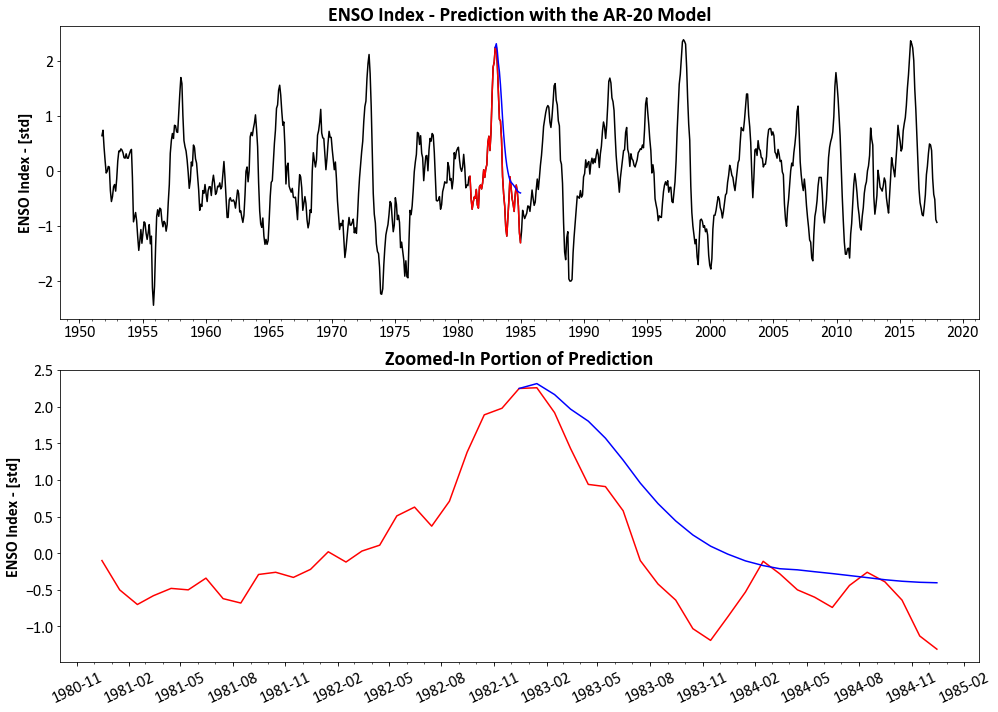

In [13]:
#=======================================================================
# Plot the results.
#=======================================================================
fig,(ax1,ax2) = plt.subplots(2,figsize=(14,10))
ax1.plot(date,y,'k-')
ax1.plot(date[it-24:it+25],y[it-24:it+25],'r-')
ax1.plot(date[it:it+imon+1],ypredict[it:it+imon+1],'b-')

ax1.xaxis.set_major_locator(YearLocator(5))
ax1.xaxis.set_minor_locator(YearLocator(1))
ax1.xaxis.set_major_formatter(DateFormatter('%Y'))

ax2.plot(date[it-24:it+25],y[it-24:it+25],'r-')
ax2.plot(date[it:it+imon+1],ypredict[it:it+imon+1],'b-')

ax2.xaxis.set_major_locator(MonthLocator(range(1, 13), bymonthday=1, interval=3))
ax2.xaxis.set_minor_locator(MonthLocator(range(1, 13), bymonthday=1, interval=1))
ax2.xaxis.set_major_formatter(DateFormatter('%Y-%m'))

for i in ax1.xaxis.get_ticklabels()+ax1.yaxis.get_ticklabels()\
         +ax2.xaxis.get_ticklabels()+ax2.yaxis.get_ticklabels():
    i.set_family('Calibri')
    i.set_size(16)

for i in ax2.xaxis.get_ticklabels():
    i.set_rotation(25)

ax1.set_title('ENSO Index - Prediction with the AR-%d Model'%ORDER,name='Calibri',\
             weight='bold',size=20)
ax1.set_ylabel('ENSO Index - [std]',name='Calibri',weight='bold',size=16)
ax2.set_ylabel('ENSO Index - [std]',name='Calibri',weight='bold',size=16)
ax2.set_title('Zoomed-In Portion of Prediction',name='Calibri',weight='bold',size=20)

fig.tight_layout()
plt.show(block=False)


In [17]:
#=======================================================================
# How many terms should we retain? Let's take a look at the AIC and BIC.
#=======================================================================
kMax = 40 # Max AR model to test

AIC = np.ones((kMax,))*np.nan
BIC = np.ones((kMax,))*np.nan
se2 = np.ones((kMax,))*np.nan

for k in range(1,kMax+1):
    alpha,yhat = ARModel(ENSO['index'],ORDER=k)
    y = ENSO['index'][k:]
    n = yhat.size # Number of samples
    
    #=======================================================================
    # AIC and BIC formula from Wilks
    #=======================================================================
    if k == 1:
        se2[k-1] = ((n-1)/float(n-2))*(1-alpha**2)*np.nanvar(y)
    else:
        se2[k-1] = se2[k-2]*(1-alpha[-1]**2)
    
    AIC[k-1] = n*np.log( n*se2[k-1]/float(n-k-1) ) + 2*(k+1)
    BIC[k-1] = n*np.log( n*se2[k-1]/float(n-k-1) ) + (k+1)*np.log(n)
    
    #=======================================================================
    # Simpler way if you assume errors are normally distributed.
    #=======================================================================
    # Calculate the sum of the square of the errors  
#     sse = np.nansum((y - yhat)**2)
    
#     AIC[k-1] = n*np.log(sse/float(n)) + 2*(k+1)
#     BIC[k-1] = n*np.log(sse/float(n)) + (k+1)*np.log(n)

minOrder = np.where(AIC == AIC.min())[0]
print 'The smallest AIC score is: %5.2f, which corresponds to the AR-%d model.'\
    %(AIC.min(),minOrder+1)

minOrder = np.where(BIC == BIC.min())[0]
print 'The smallest BIC score is: %5.2f, which corresponds to the AR-%d model.'\
    %(BIC.min(),minOrder+1)

The smallest AIC score is: -2420.72, which corresponds to the AR-2 model.
The smallest BIC score is: -2406.62, which corresponds to the AR-2 model.


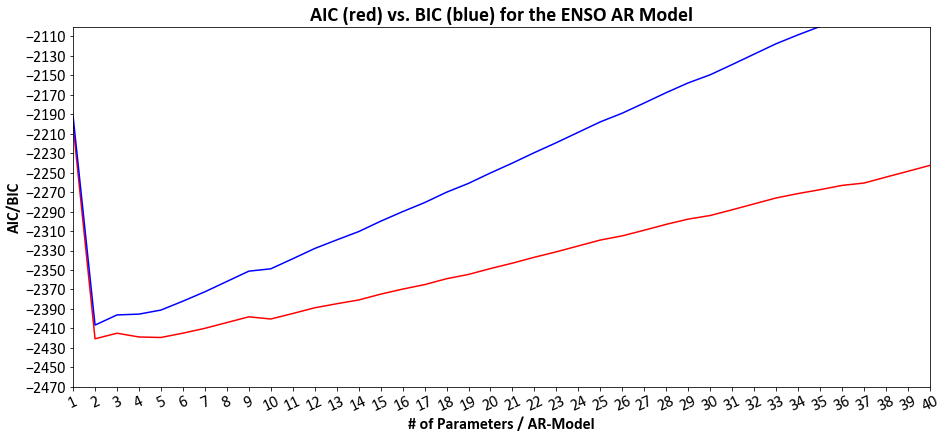

In [16]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)
ax.set_position([0.1,0.1,0.85,0.5])

ax.plot(np.arange(1,kMax+1),AIC,'r-')
ax.plot(np.arange(1,kMax+1),BIC,'b-')
ax.set(xlim=[1,kMax],xticks=np.arange(1,kMax+1),\
       ylim=[-2470,-2100],yticks=np.arange(-2470,-2099,20))

for i in ax.xaxis.get_ticklabels()+ax.yaxis.get_ticklabels():
    i.set_family('Calibri')
    i.set_size(16)
    
for i in ax.xaxis.get_ticklabels():
    i.set_rotation(25)
    

ax.set_title('AIC (red) vs. BIC (blue) for the ENSO AR Model',name='Calibri',\
             weight='bold',size=20)
ax.set_xlabel('# of Parameters / AR-Model',name='Calibri',weight='bold',size=16)
ax.set_ylabel('AIC/BIC',name='Calibri',weight='bold',size=16)

plt.show(block=False)